In [ ]:
"""Import the required packages"""

import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

warnings.filterwarnings('ignore', category=FutureWarning, module='skimage')
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

In [70]:
""" Get and resize train images and masks """
def nucleus_data( path, train = True):
    img_width = 128
    img_height = 128
    img_channels = 3
    if train:
        idx = next(os.walk(path))[1]
        
        img_train = np.zeros((len(idx), img_height, img_width, img_channels), dtype=np.uint8)
        mask_train = np.zeros((len(idx), img_height, img_width, 1), dtype=np.bool)

        print('Getting and resizing train images and masks ... ')

        # here we are getting the individual images and resizing them with respect to our parameter

        for n, id_ in tqdm(enumerate(idx), total = len(idx)):
            img_path = path + id_
            img = imread(img_path + '/images/' + id_ + '.png')[:,:,:img_channels]
            img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
            img_train[n] = img
            mask = np.zeros((img_height, img_width, 1), dtype=np.bool)
            for mask_file in next(os.walk(img_path + '/masks/'))[2]:
                mask_ = imread(img_path + '/masks/' + mask_file)
                mask_ = np.expand_dims(resize(mask_, (img_height, img_width), mode='constant', 
                                              preserve_range=True), axis=-1)
                mask = np.maximum(mask, mask_)
            mask_train[n] = mask
            
        return img_train, mask_train
    
    else:
        
        idx = next(os.walk(path))[1]
        
        img_test = np.zeros((len(idx), img_height, img_width, img_channels), dtype=np.uint8)
        
        print('Getting and resizing test images ... ')
        
        for n, id_ in tqdm(enumerate(idx), total=len(idx)):
            img_path = path + id_
            img = imread(img_path + '/images/' + id_ + '.png')[:,:,:img_channels]
            img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
            img_test[n] = img

        return img_test 

In [49]:
X_train, Y_train = nucleus_data("nuclei_datasets/stage1_train/")

Getting and resizing train images and masks ... 


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [02:19<00:00,  4.79it/s]


In [50]:
X_test = nucleus_data("nuclei_datasets/stage1_test/", train = False)

Getting and resizing test images ... 


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 54.86it/s]


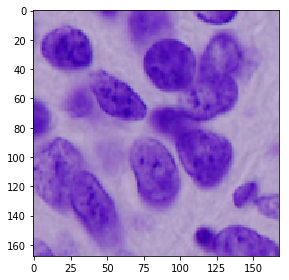

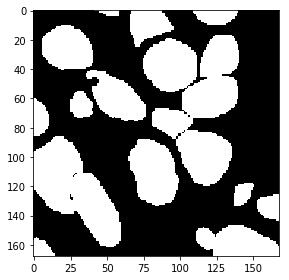

In [42]:
# Check if training data looks all right
ix = random.randint(0, 500)
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [43]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)



In [78]:
# Build U-Net model
inputs = Input((128, 128, 3))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, 128, 128, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_97 (Conv2D)              (None, 128, 128, 16) 448         lambda_8[0][0]                   
__________________________________________________________________________________________________
dropout_48 (Dropout)            (None, 128, 128, 16) 0           conv2d_97[0][0]                  
__________________________________________________________________________________________________
conv2d_98 

__________________________________________________________________________________________________
conv2d_113 (Conv2D)             (None, 128, 128, 16) 4624        concatenate_21[0][0]             
__________________________________________________________________________________________________
dropout_56 (Dropout)            (None, 128, 128, 16) 0           conv2d_113[0][0]                 
__________________________________________________________________________________________________
conv2d_114 (Conv2D)             (None, 128, 128, 16) 2320        dropout_56[0][0]                 
__________________________________________________________________________________________________
conv2d_115 (Conv2D)             (None, 128, 128, 1)  17          conv2d_114[0][0]                 
Total params: 1,941,105
Trainable params: 1,941,105
Non-trainable params: 0
__________________________________________________________________________________________________


In [10]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
# specify the weights
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/50
603/603 [==============================] - ETA: 5:14 - loss: 0.6932 - mean_iou: 0.0000e+ - ETA: 3:34 - loss: 0.6324 - mean_iou: 0.2005   - ETA: 2:57 - loss: 0.5900 - mean_iou: 0.27 - ETA: 2:38 - loss: 0.5716 - mean_iou: 0.30 - ETA: 2:29 - loss: 0.5445 - mean_iou: 0.33 - ETA: 2:22 - loss: 0.5303 - mean_iou: 0.34 - ETA: 2:14 - loss: 0.5233 - mean_iou: 0.35 - ETA: 2:09 - loss: 0.5062 - mean_iou: 0.36 - ETA: 2:03 - loss: 0.4894 - mean_iou: 0.37 - ETA: 1:57 - loss: 0.4867 - mean_iou: 0.37 - ETA: 1:51 - loss: 0.4726 - mean_iou: 0.38 - ETA: 1:45 - loss: 0.4595 - mean_iou: 0.38 - ETA: 1:40 - loss: 0.4512 - mean_iou: 0.38 - ETA: 1:34 - loss: 0.4423 - mean_iou: 0.39 - ETA: 1:30 - loss: 0.4308 - mean_iou: 0.39 - ETA: 1:26 - loss: 0.4218 - mean_iou: 0.39 - ETA: 1:21 - loss: 0.4110 - mean_iou: 0.39 - ETA: 1:17 - loss: 0.4058 - mean_iou: 0.40 - ETA: 1:12 - loss: 0.3945 - mean_iou: 0.40 - ETA: 1:08 - loss: 0.3851 - mean_iou: 0.40 - ETA: 1:04 - l

603/603 [==============================] - ETA: 2:04 - loss: 0.1259 - mean_iou: 0.71 - ETA: 1:58 - loss: 0.1163 - mean_iou: 0.71 - ETA: 1:55 - loss: 0.1169 - mean_iou: 0.71 - ETA: 1:51 - loss: 0.1156 - mean_iou: 0.71 - ETA: 1:49 - loss: 0.1170 - mean_iou: 0.71 - ETA: 1:45 - loss: 0.1215 - mean_iou: 0.71 - ETA: 1:43 - loss: 0.1226 - mean_iou: 0.71 - ETA: 1:40 - loss: 0.1204 - mean_iou: 0.71 - ETA: 1:36 - loss: 0.1223 - mean_iou: 0.71 - ETA: 1:33 - loss: 0.1204 - mean_iou: 0.71 - ETA: 1:29 - loss: 0.1162 - mean_iou: 0.71 - ETA: 1:26 - loss: 0.1151 - mean_iou: 0.71 - ETA: 1:22 - loss: 0.1140 - mean_iou: 0.71 - ETA: 1:19 - loss: 0.1129 - mean_iou: 0.71 - ETA: 1:15 - loss: 0.1120 - mean_iou: 0.71 - ETA: 1:12 - loss: 0.1110 - mean_iou: 0.71 - ETA: 1:09 - loss: 0.1106 - mean_iou: 0.71 - ETA: 1:06 - loss: 0.1101 - mean_iou: 0.71 - ETA: 1:02 - loss: 0.1102 - mean_iou: 0.71 - ETA: 59s - loss: 0.1093 - mean_iou: 0.7189 - ETA: 55s - loss: 0.1114 - mean_iou: 0.719 - ETA: 52s - loss: 0.1115 - mean_i

603/603 [==============================] - ETA: 2:04 - loss: 0.0981 - mean_iou: 0.76 - ETA: 1:57 - loss: 0.0994 - mean_iou: 0.76 - ETA: 1:55 - loss: 0.0900 - mean_iou: 0.76 - ETA: 1:51 - loss: 0.0869 - mean_iou: 0.76 - ETA: 1:48 - loss: 0.0855 - mean_iou: 0.76 - ETA: 1:45 - loss: 0.0811 - mean_iou: 0.76 - ETA: 1:41 - loss: 0.0778 - mean_iou: 0.76 - ETA: 1:38 - loss: 0.0818 - mean_iou: 0.76 - ETA: 1:34 - loss: 0.0856 - mean_iou: 0.76 - ETA: 1:31 - loss: 0.0847 - mean_iou: 0.76 - ETA: 1:28 - loss: 0.0833 - mean_iou: 0.76 - ETA: 1:25 - loss: 0.0847 - mean_iou: 0.76 - ETA: 1:21 - loss: 0.0835 - mean_iou: 0.76 - ETA: 1:18 - loss: 0.0822 - mean_iou: 0.76 - ETA: 1:15 - loss: 0.0828 - mean_iou: 0.76 - ETA: 1:11 - loss: 0.0842 - mean_iou: 0.76 - ETA: 1:08 - loss: 0.0865 - mean_iou: 0.76 - ETA: 1:05 - loss: 0.0848 - mean_iou: 0.76 - ETA: 1:02 - loss: 0.0839 - mean_iou: 0.77 - ETA: 58s - loss: 0.0840 - mean_iou: 0.7702 - ETA: 55s - loss: 0.0836 - mean_iou: 0.770 - ETA: 52s - loss: 0.0818 - mean_i

603/603 [==============================] - ETA: 1:57 - loss: 0.0747 - mean_iou: 0.79 - ETA: 1:58 - loss: 0.0685 - mean_iou: 0.79 - ETA: 1:56 - loss: 0.0764 - mean_iou: 0.79 - ETA: 1:52 - loss: 0.0760 - mean_iou: 0.79 - ETA: 1:50 - loss: 0.0875 - mean_iou: 0.79 - ETA: 1:46 - loss: 0.0851 - mean_iou: 0.79 - ETA: 1:43 - loss: 0.0890 - mean_iou: 0.79 - ETA: 1:39 - loss: 0.0853 - mean_iou: 0.79 - ETA: 1:35 - loss: 0.0870 - mean_iou: 0.79 - ETA: 1:32 - loss: 0.0836 - mean_iou: 0.79 - ETA: 1:29 - loss: 0.0804 - mean_iou: 0.79 - ETA: 1:26 - loss: 0.0781 - mean_iou: 0.79 - ETA: 1:22 - loss: 0.0788 - mean_iou: 0.79 - ETA: 1:19 - loss: 0.0787 - mean_iou: 0.79 - ETA: 1:16 - loss: 0.0778 - mean_iou: 0.79 - ETA: 1:12 - loss: 0.0780 - mean_iou: 0.79 - ETA: 1:09 - loss: 0.0783 - mean_iou: 0.79 - ETA: 1:05 - loss: 0.0788 - mean_iou: 0.79 - ETA: 1:02 - loss: 0.0786 - mean_iou: 0.79 - ETA: 59s - loss: 0.0794 - mean_iou: 0.7963 - ETA: 56s - loss: 0.0790 - mean_iou: 0.796 - ETA: 53s - loss: 0.0790 - mean_i

603/603 [==============================] - ETA: 2:19 - loss: 0.0411 - mean_iou: 0.81 - ETA: 2:16 - loss: 0.0475 - mean_iou: 0.81 - ETA: 2:10 - loss: 0.0602 - mean_iou: 0.81 - ETA: 2:07 - loss: 0.0603 - mean_iou: 0.81 - ETA: 2:04 - loss: 0.0664 - mean_iou: 0.81 - ETA: 2:00 - loss: 0.0752 - mean_iou: 0.81 - ETA: 1:56 - loss: 0.0750 - mean_iou: 0.81 - ETA: 1:52 - loss: 0.0744 - mean_iou: 0.81 - ETA: 1:47 - loss: 0.0781 - mean_iou: 0.81 - ETA: 1:43 - loss: 0.0743 - mean_iou: 0.81 - ETA: 1:38 - loss: 0.0747 - mean_iou: 0.81 - ETA: 1:34 - loss: 0.0757 - mean_iou: 0.81 - ETA: 1:30 - loss: 0.0748 - mean_iou: 0.81 - ETA: 1:26 - loss: 0.0752 - mean_iou: 0.81 - ETA: 1:23 - loss: 0.0743 - mean_iou: 0.81 - ETA: 1:19 - loss: 0.0731 - mean_iou: 0.81 - ETA: 1:16 - loss: 0.0745 - mean_iou: 0.81 - ETA: 1:12 - loss: 0.0756 - mean_iou: 0.81 - ETA: 1:08 - loss: 0.0760 - mean_iou: 0.81 - ETA: 1:05 - loss: 0.0749 - mean_iou: 0.81 - ETA: 1:01 - loss: 0.0757 - mean_iou: 0.81 - ETA: 57s - loss: 0.0754 - mean_io

603/603 [==============================] - ETA: 2:10 - loss: 0.0997 - mean_iou: 0.82 - ETA: 2:07 - loss: 0.0940 - mean_iou: 0.82 - ETA: 2:03 - loss: 0.0804 - mean_iou: 0.82 - ETA: 1:57 - loss: 0.0795 - mean_iou: 0.82 - ETA: 1:53 - loss: 0.0763 - mean_iou: 0.82 - ETA: 1:48 - loss: 0.0715 - mean_iou: 0.82 - ETA: 1:43 - loss: 0.0690 - mean_iou: 0.82 - ETA: 1:38 - loss: 0.0747 - mean_iou: 0.82 - ETA: 1:33 - loss: 0.0740 - mean_iou: 0.82 - ETA: 1:29 - loss: 0.0729 - mean_iou: 0.82 - ETA: 1:25 - loss: 0.0738 - mean_iou: 0.82 - ETA: 1:21 - loss: 0.0723 - mean_iou: 0.82 - ETA: 1:17 - loss: 0.0722 - mean_iou: 0.82 - ETA: 1:14 - loss: 0.0719 - mean_iou: 0.82 - ETA: 1:10 - loss: 0.0710 - mean_iou: 0.82 - ETA: 1:07 - loss: 0.0702 - mean_iou: 0.82 - ETA: 1:04 - loss: 0.0701 - mean_iou: 0.82 - ETA: 1:00 - loss: 0.0691 - mean_iou: 0.82 - ETA: 57s - loss: 0.0689 - mean_iou: 0.8217 - ETA: 54s - loss: 0.0708 - mean_iou: 0.821 - ETA: 51s - loss: 0.0713 - mean_iou: 0.821 - ETA: 48s - loss: 0.0714 - mean_i

603/603 [==============================] - ETA: 2:04 - loss: 0.0506 - mean_iou: 0.82 - ETA: 1:54 - loss: 0.0563 - mean_iou: 0.82 - ETA: 1:48 - loss: 0.0534 - mean_iou: 0.82 - ETA: 1:47 - loss: 0.0549 - mean_iou: 0.82 - ETA: 1:42 - loss: 0.0610 - mean_iou: 0.82 - ETA: 1:38 - loss: 0.0617 - mean_iou: 0.82 - ETA: 1:34 - loss: 0.0609 - mean_iou: 0.82 - ETA: 1:31 - loss: 0.0591 - mean_iou: 0.82 - ETA: 1:27 - loss: 0.0603 - mean_iou: 0.82 - ETA: 1:24 - loss: 0.0610 - mean_iou: 0.82 - ETA: 1:20 - loss: 0.0631 - mean_iou: 0.82 - ETA: 1:17 - loss: 0.0639 - mean_iou: 0.82 - ETA: 1:15 - loss: 0.0644 - mean_iou: 0.82 - ETA: 1:12 - loss: 0.0636 - mean_iou: 0.82 - ETA: 1:09 - loss: 0.0663 - mean_iou: 0.82 - ETA: 1:06 - loss: 0.0670 - mean_iou: 0.82 - ETA: 1:04 - loss: 0.0663 - mean_iou: 0.82 - ETA: 1:01 - loss: 0.0661 - mean_iou: 0.82 - ETA: 58s - loss: 0.0649 - mean_iou: 0.8296 - ETA: 55s - loss: 0.0656 - mean_iou: 0.829 - ETA: 52s - loss: 0.0657 - mean_iou: 0.829 - ETA: 49s - loss: 0.0658 - mean_i

603/603 [==============================] - ETA: 2:18 - loss: 0.0973 - mean_iou: 0.83 - ETA: 2:06 - loss: 0.0759 - mean_iou: 0.83 - ETA: 1:57 - loss: 0.0752 - mean_iou: 0.83 - ETA: 1:56 - loss: 0.0701 - mean_iou: 0.83 - ETA: 1:52 - loss: 0.0744 - mean_iou: 0.83 - ETA: 1:48 - loss: 0.0762 - mean_iou: 0.83 - ETA: 1:45 - loss: 0.0768 - mean_iou: 0.83 - ETA: 1:43 - loss: 0.0772 - mean_iou: 0.83 - ETA: 1:41 - loss: 0.0745 - mean_iou: 0.83 - ETA: 1:37 - loss: 0.0737 - mean_iou: 0.83 - ETA: 1:32 - loss: 0.0720 - mean_iou: 0.83 - ETA: 1:29 - loss: 0.0701 - mean_iou: 0.83 - ETA: 1:25 - loss: 0.0678 - mean_iou: 0.83 - ETA: 1:21 - loss: 0.0671 - mean_iou: 0.83 - ETA: 1:16 - loss: 0.0681 - mean_iou: 0.83 - ETA: 1:12 - loss: 0.0682 - mean_iou: 0.83 - ETA: 1:09 - loss: 0.0665 - mean_iou: 0.83 - ETA: 1:05 - loss: 0.0661 - mean_iou: 0.83 - ETA: 1:01 - loss: 0.0665 - mean_iou: 0.83 - ETA: 58s - loss: 0.0664 - mean_iou: 0.8359 - ETA: 54s - loss: 0.0679 - mean_iou: 0.835 - ETA: 50s - loss: 0.0676 - mean_i

In [79]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


65/65 [==============================] - ETA:  - ETA:  - 4s 58ms/step


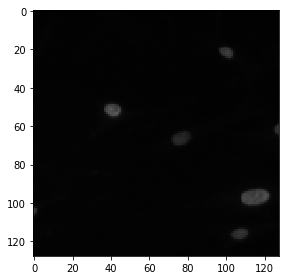

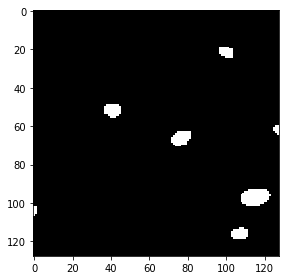

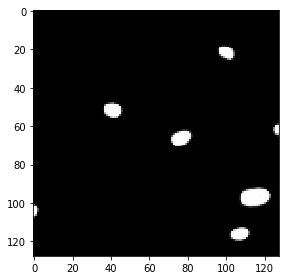

In [127]:
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

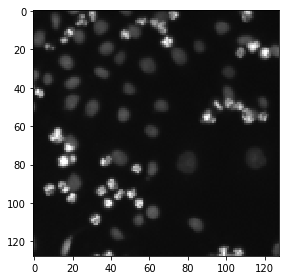

C:\Users\RAKESH V\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


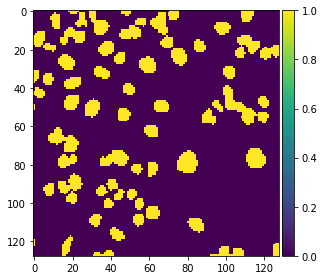

In [129]:
# Perform a sanity check on some random test samples
ix = random.randint(0, len(preds_test_t))
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()